In [18]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import os
from sklearn.model_selection import train_test_split, cross_val_score
from PIL import Image, ImageFilter
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
def resize_max_n(picture, n):
    img = Image.fromarray(picture)
    h, v = picture.shape[0], picture.shape[1]
    dmax = max(v, h)
    new_v = (v * n) // dmax
    new_h = (h * n) // dmax
    return np.asarray(img.resize((new_h, new_v)))
    
    

def make_square(picture):
    h = picture.shape[0]
    w = picture.shape[1]
    
    if h < w:
        
        h1 = (w - h) // 2
        h2 = (w - h) - h1
        top = np.full((h1, w), picture.mean())
        bottom = np.full((h2, w), picture.mean())
        picture = np.vstack((top, picture, bottom))
        
    if h > w:
        w1 = (h - w) // 2
        w2 = (h - w) - w1
        left = np.full((h, w1), picture.mean())
        right = np.full((h, w2), picture.mean())
        picture = np.hstack((left, picture, right))
    
    return picture


def normalize(picture):
    return (picture - np.mean(picture)) / np.std(picture)


def smooth(picture, eps=2):
    new_picture = np.zeros(picture.shape)
    for i in range(picture.shape[0]):
        for j in range(picture.shape[1]):
            new_picture[i, j] = np.mean(picture[max(0, i - eps): i + eps, max(0, j - eps): j + eps])
    return new_picture


def make_center_darker(picture):
    h, v = picture.shape[0], picture.shape[1]
    a1 = (np.mean(picture[: h // 3, : v // 3]) + np.mean(picture[: h // 3, 2 * v // 3:]) +
          np.mean(picture[2 * h // 3:, : v // 3]) + np.mean(picture[2 * h // 3:, 2 * v // 3:])) / 4
    a2 = np.mean(picture[h // 3: 2 * h // 3, v //3 : 2 * v // 3])
    
    if a1 > a2:
        picture = -picture
    return picture


def cut_picture(picture, step=10, alpha=0.15, sp=20):
    hs = [np.std(picture[i * step: (i + 1) * step, :]) for i in range(picture.shape[0] // step)]
    r = max(hs) - min(hs)
    q = min(hs) + alpha * r
    big_hs = [i * step for i in range(len(hs)) if hs[i] > q]
    ih_min, ih_max = max(min(big_hs) - sp, 0), min(max(big_hs) + sp, picture.shape[0])
    
    vs = [np.std(picture[:, i * step: (i + 1) * step]) for i in range(picture.shape[1] // step)]
    r = max(vs) - min(vs)
    q = min(vs) + alpha * r
    big_vs = [i * step for i in range(len(vs)) if vs[i] > q]
    iv_min, iv_max = max(min(big_vs) - sp, 0), min(max(big_vs) + sp, picture.shape[1])
    return picture[ih_min: ih_max, iv_min: iv_max]


def make_symmetrical(picture, step=10):
    results = []
    for i in range(picture.shape[1] // 3, 2 * picture.shape[1] // 3, step):
        s = min(i, picture.shape[1] - i)
        pic1 = picture[:, max(0, i - s):i]
        pic2 = picture[:, i: min(i + s, picture.shape[1])]
        assert pic1.shape == pic2.shape
        n1 = np.sum((pic1 - pic1.mean()) * (pic1 - pic1.mean()))
        n2 = np.sum((pic2 - pic2.mean()) * (pic2 - pic2.mean()))
        n3 = np.sum((pic1 - pic1.mean()) * (np.flip(pic2, 1) - pic2.mean()))
        res = n3 / math.sqrt(n1 * n2)
        results.append(abs(res))
        
    ans = picture.shape[1] // 3 + np.argmax(results) * step
    half_len = min(ans, picture.shape[1] - ans)
    picture = picture[:, ans - half_len: ans + half_len]
    return picture

In [3]:
def prepare_picture1(path, n=400, eps=2):
    
    # читаем
    picture = Image.open(path).convert('L')
    picture = np.asarray(picture)
    
    # обрезаем края
    picture = cut_picture(picture)
    
    # центрируем
    picture = make_symmetrical(picture)
    
    # уменьшаем еще
    picture = resize_max_n(picture, n)
    
    # делаем квадрат
    picture = make_square(picture)
    
    # сглаживаем
    picture = smooth(picture, eps=eps)
    
    # инвертируем при необходимости
    picture = make_center_darker(picture)
    
    # нормализуем
    picture = normalize(picture)

    return picture

In [4]:
def calculate_angles(picture, n_steps):
    eps = 0.00001
    res = [0] * n_steps
    part = math.pi / n_steps
    for i in range(1, picture.shape[0] - 1):
        for j in range(1, picture.shape[1] - 1):
            dx = picture[i + 1, j] - picture[i - 1, j]
            dy = picture[i, j + 1] - picture[i, j - 1]
            r = math.sqrt(dx ** 2 + dy ** 2)
            if r < eps:
                continue

            if dx == 0:
                phi = math.pi / 2
            else:
                phi = math.atan(dy / dx)
            a = 0
            while phi > -math.pi / 2 + a * part:
                a += 1
            pb = phi + math.pi / 2 - (a - 1) * part
            pa = part - pb
            b = a - 1
            if b < 0:
                b += n_steps
            if a == n_steps:
                a -= n_steps

            if phi != 0:
                res[b] += pb * r / part
                res[a] += pa * r / part
            else:
                res[0] += r

    return res

In [5]:
def make_features(pictures, hist_step=10, angle_step=80):
    df = pd.DataFrame()
    n = pictures[0].shape[0]
    
    # градиенты    
    angles = []
    names = []
    for picture in pictures:
        ans = []
        d = defaultdict(int)
        for i in range(0, picture.shape[0], angle_step):
            for j in range(0, picture.shape[1], angle_step):
                arr = calculate_angles(picture[i: i + angle_step, j: j + angle_step], 9)
                ans += arr
                d[tuple(arr)] += 1
        #print(d)
        angles.append(ans)
            
    for i in range(0, picture.shape[0], angle_step):
        for j in range(0, picture.shape[1], angle_step):
            names += [f'grad_{i}_{j}_{k}' for k in range(9)]
    df = pd.DataFrame(angles, columns=names)
    
    # просто гистрограмма распределния цвета по вертикали и горизонтали
    for i in range(0, n - hist_step + 1, hist_step):
        res1 = []
        res2 = []
        for picture in pictures:
            res1.append(np.sum(picture[:, i: hist_step + i]))
            res2.append(np.sum(picture[i: hist_step + i, :]))
        
        df[f'h_{i}'] = res1
        df[f'w_{i}'] = res2
                
    return df

In [6]:
dirname = 'data'


categories = [folder for folder in os.listdir(dirname)]
categories

['shirts', 'sweaters', 'T-shirts', 'skirts', 'pants', 'dresses', 'shorts']

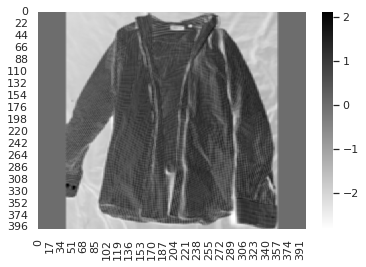

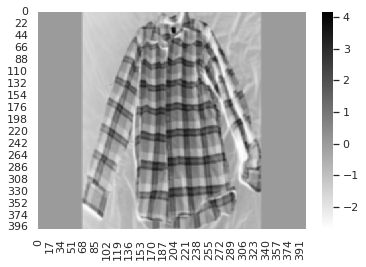

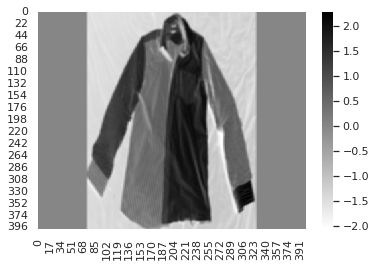

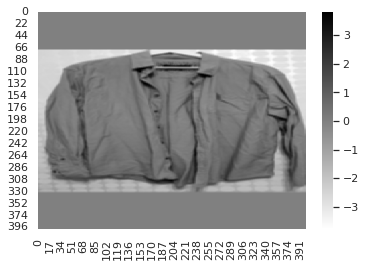

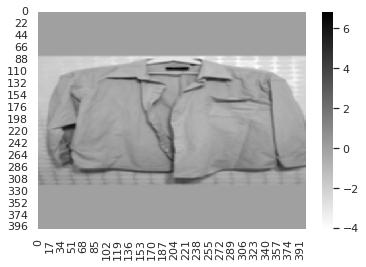

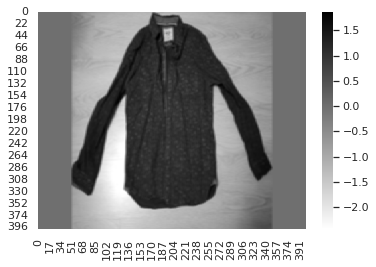

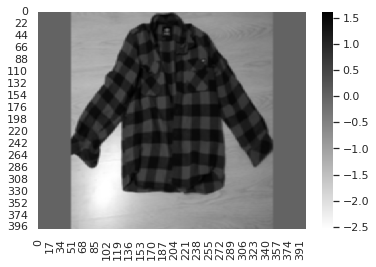

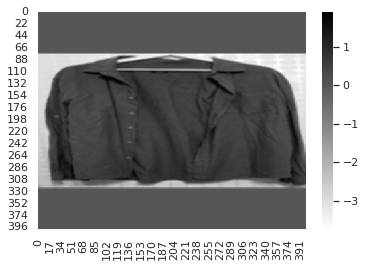

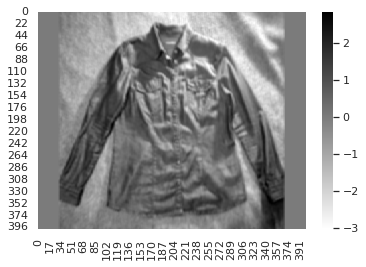

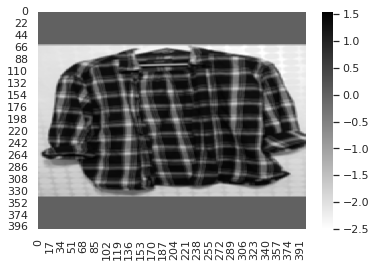

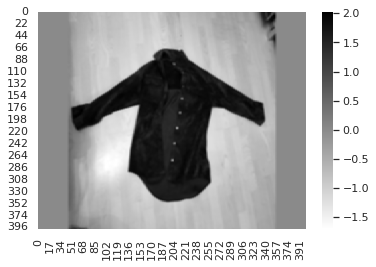

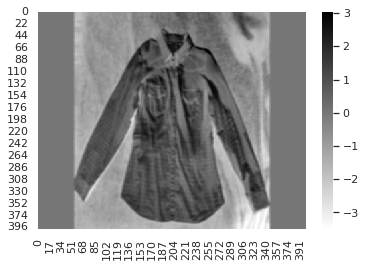

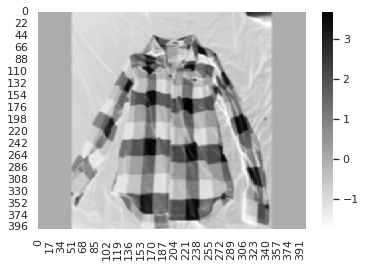

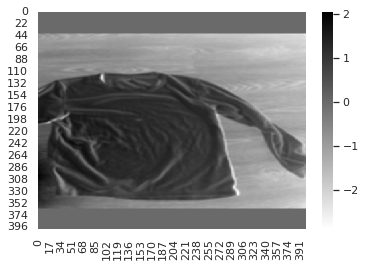

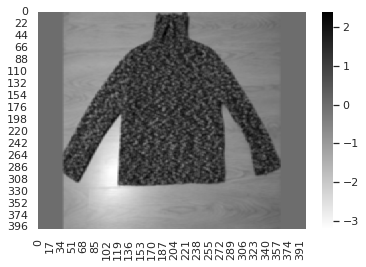

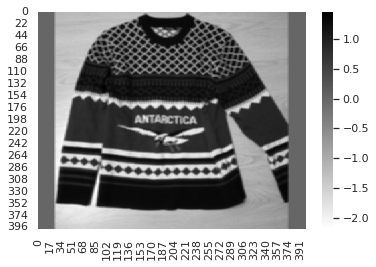

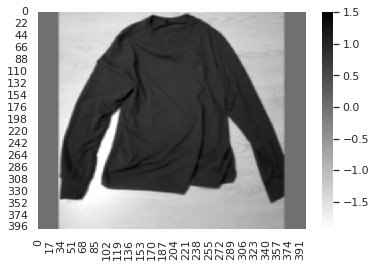

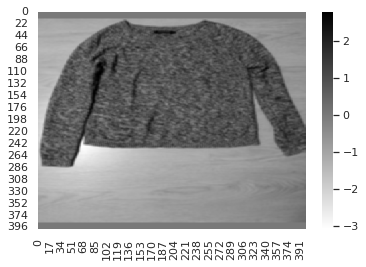

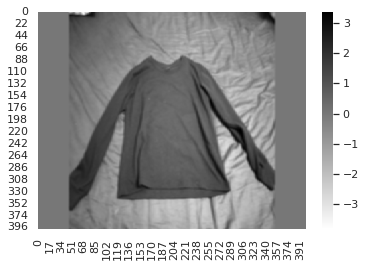

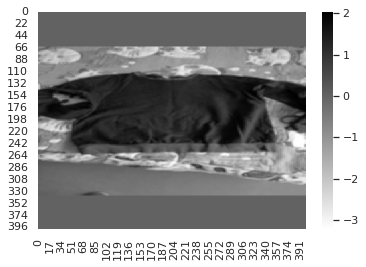

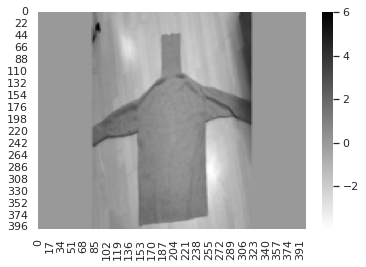

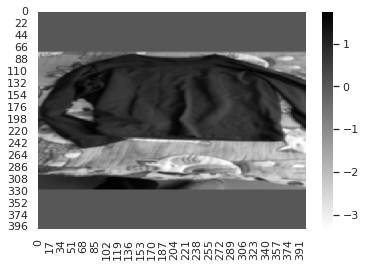

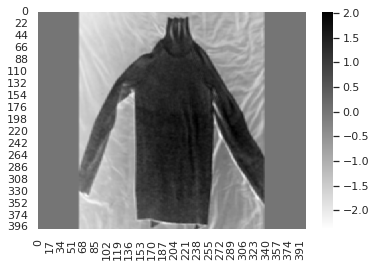

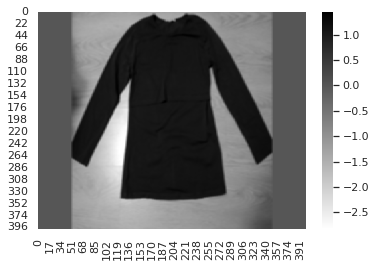

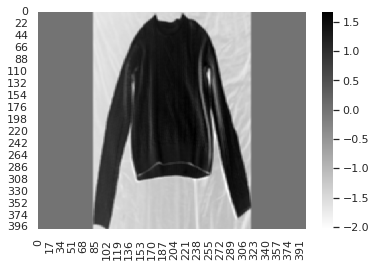

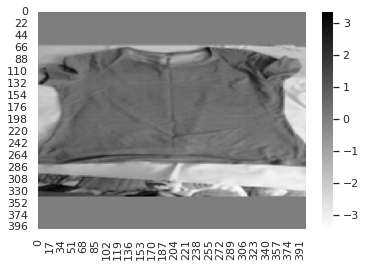

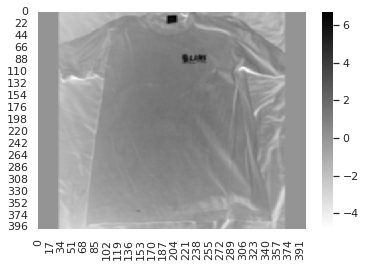

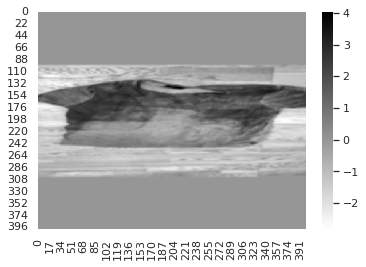

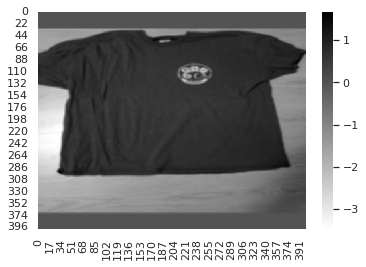

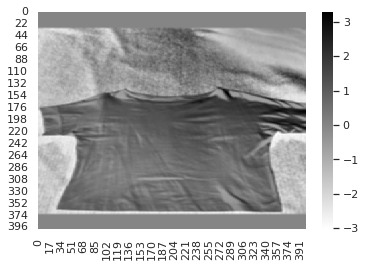

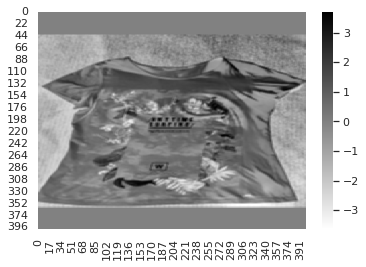

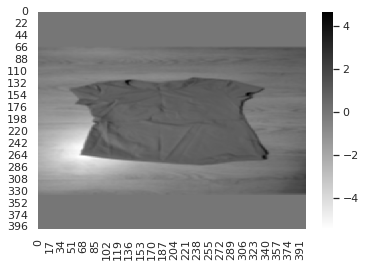

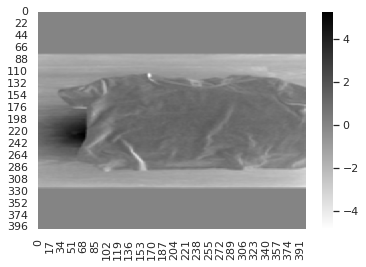

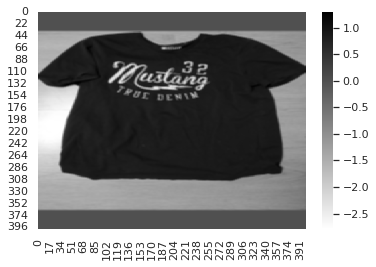

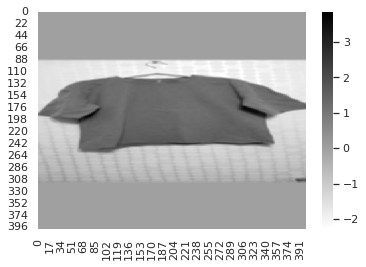

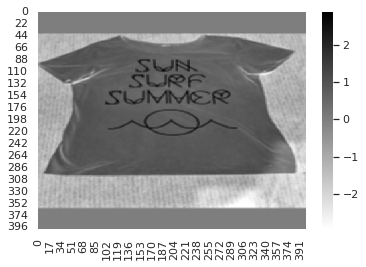

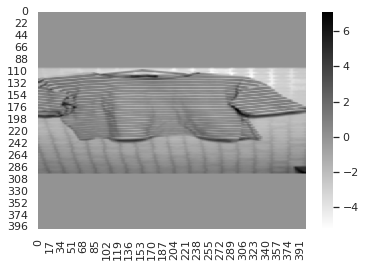

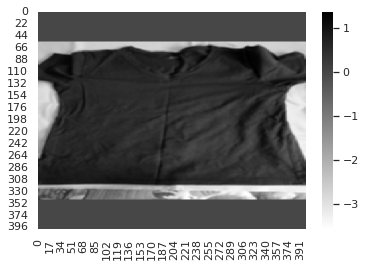

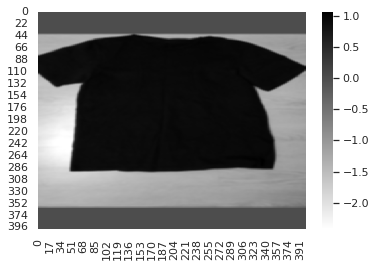

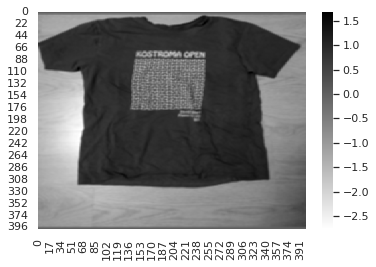

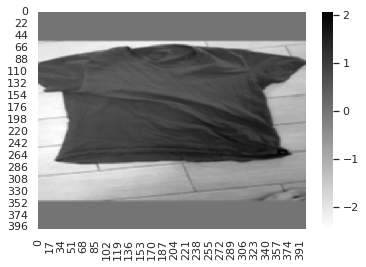

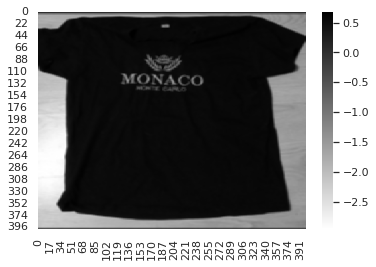

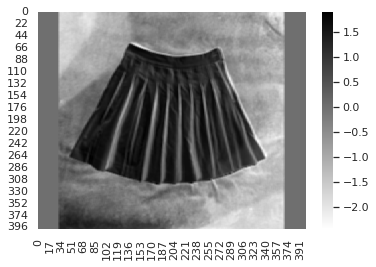

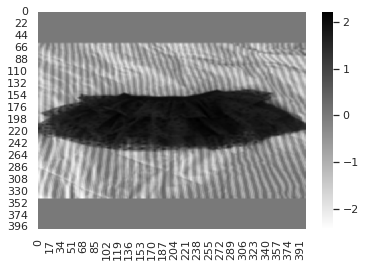

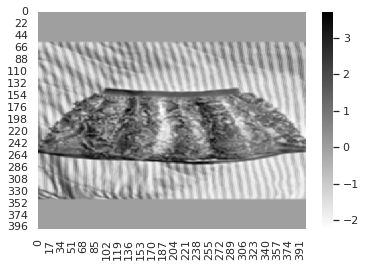

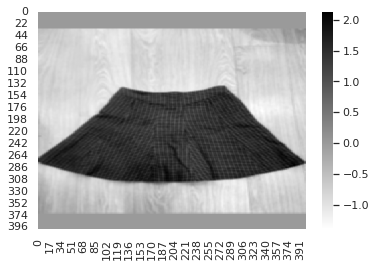

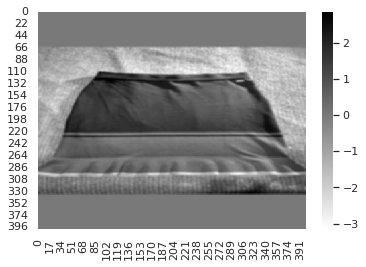

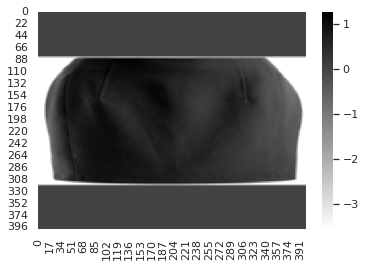

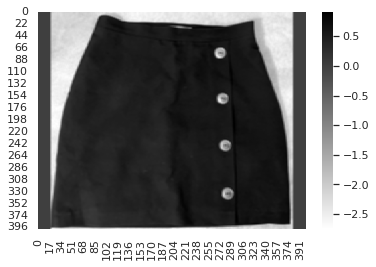

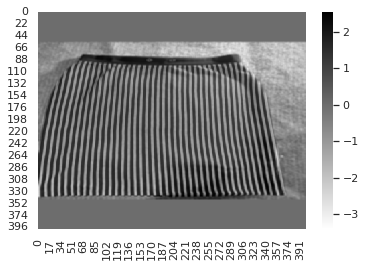

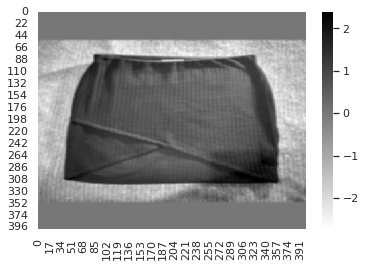

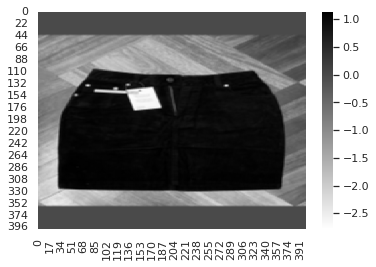

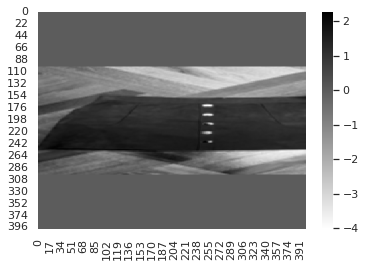

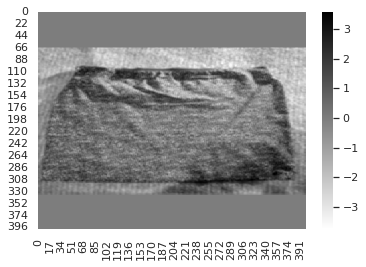

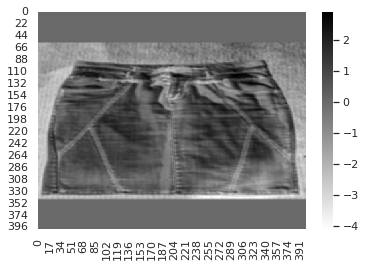

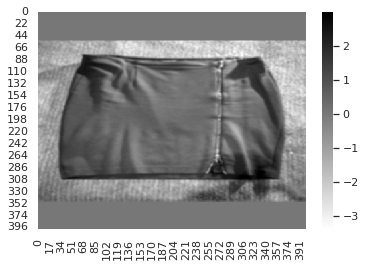

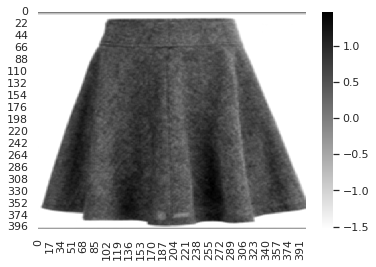

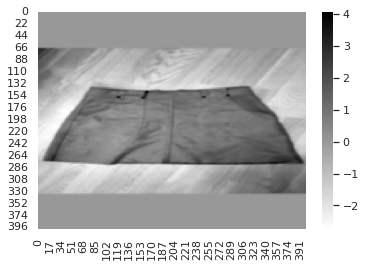

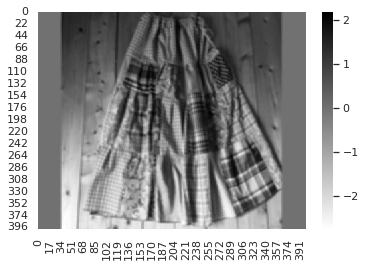

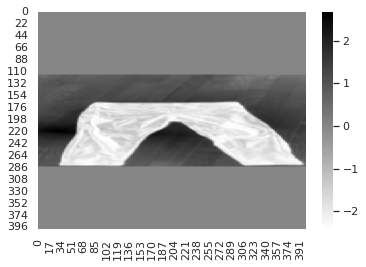

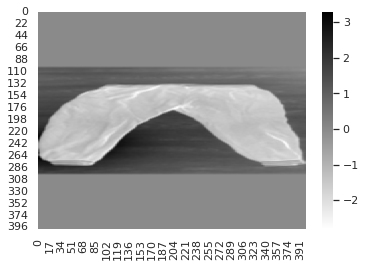

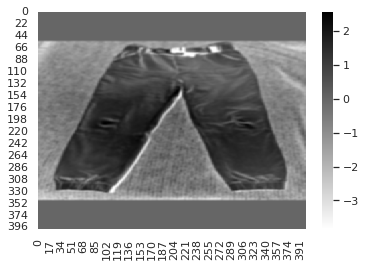

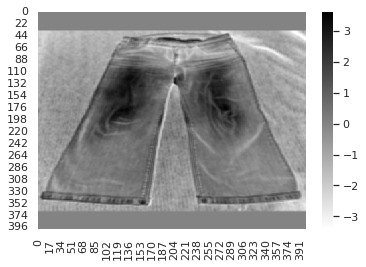

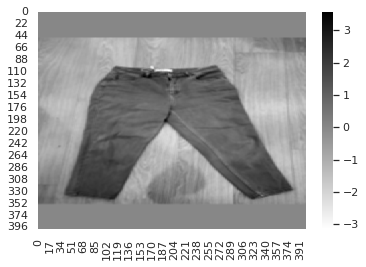

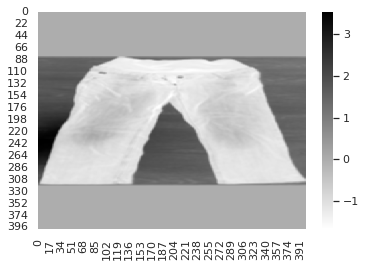

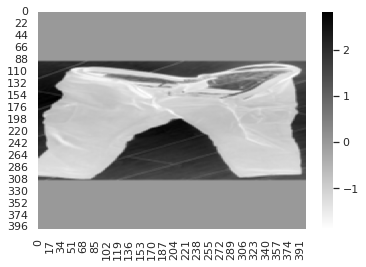

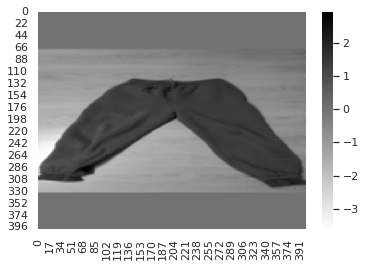

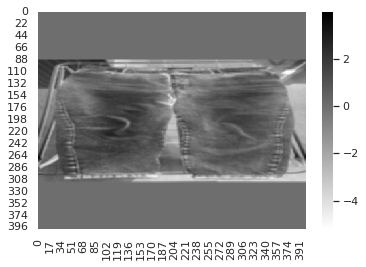

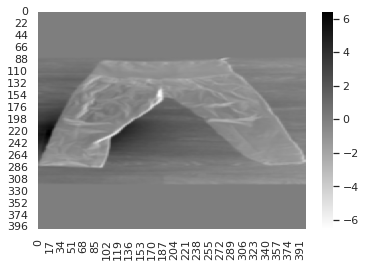

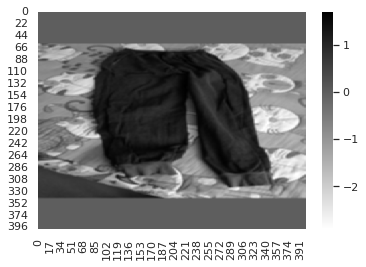

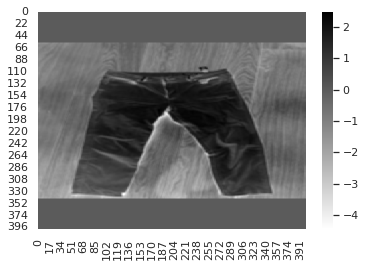

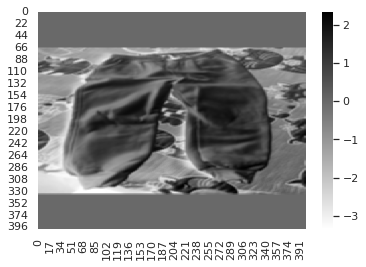

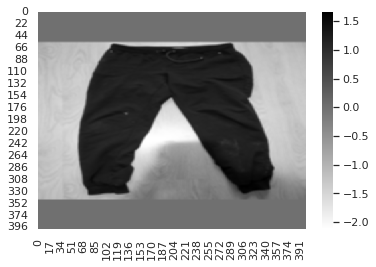

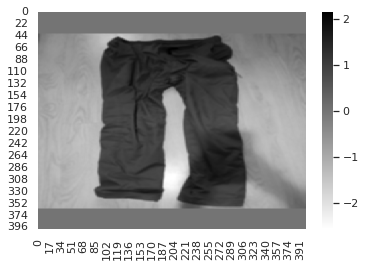

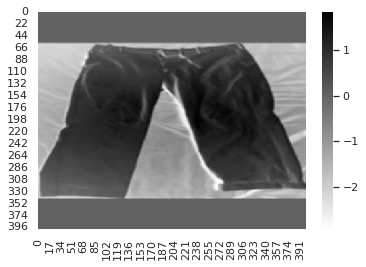

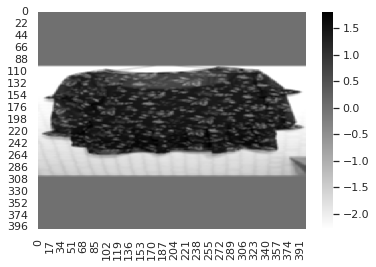

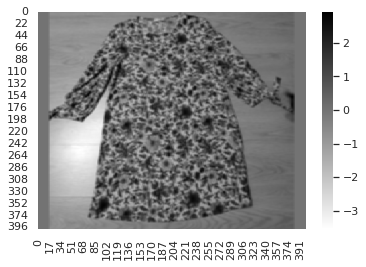

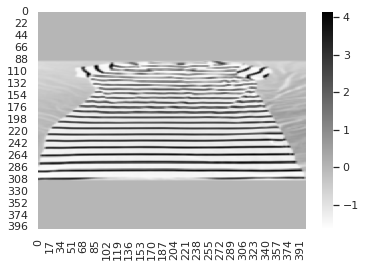

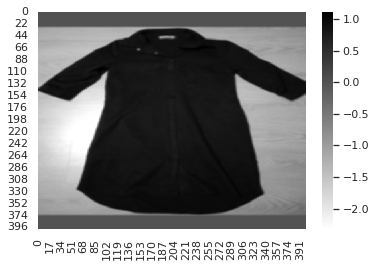

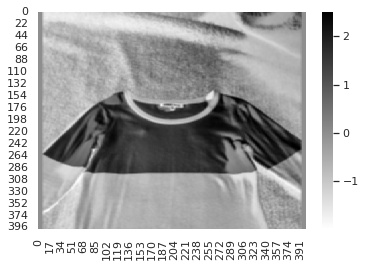

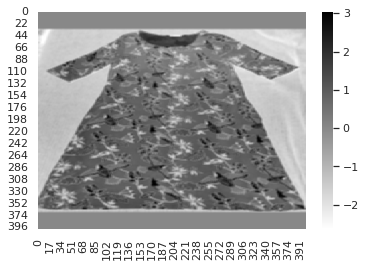

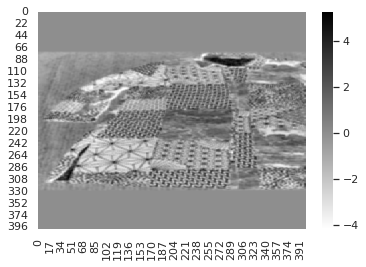

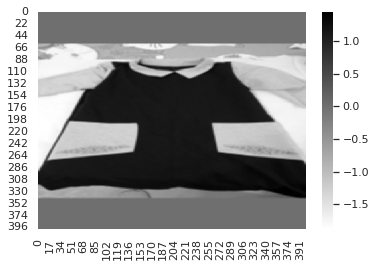

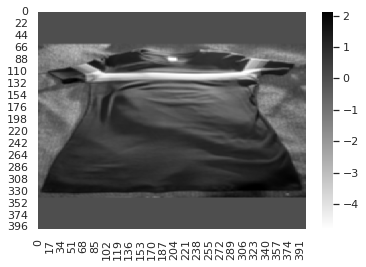

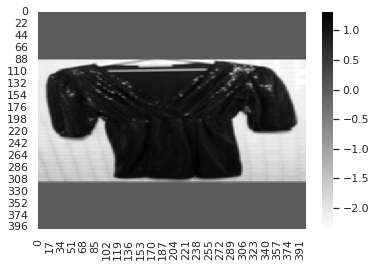

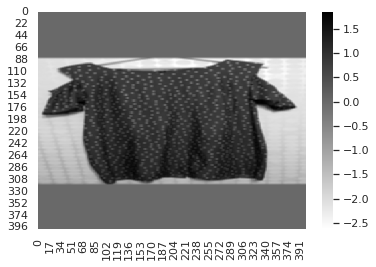

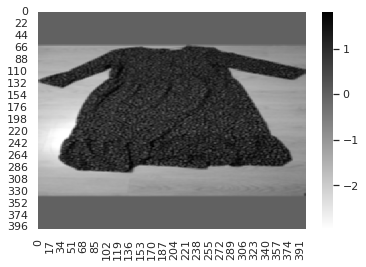

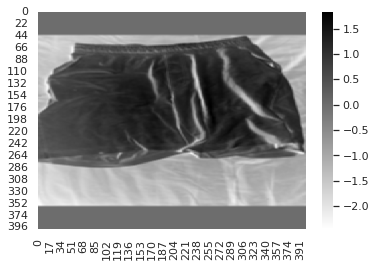

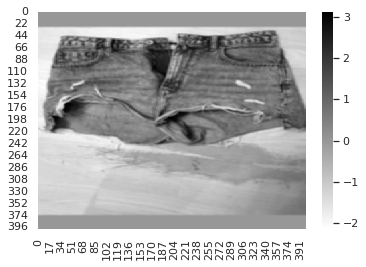

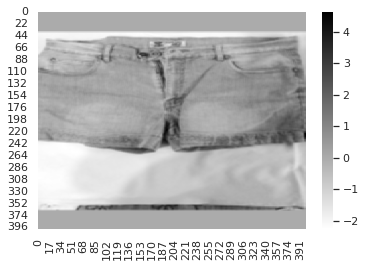

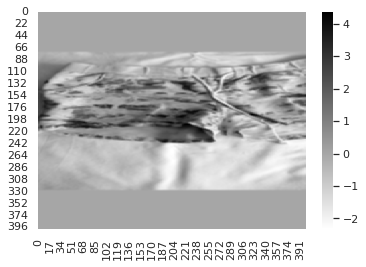

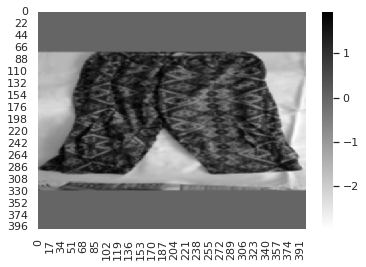

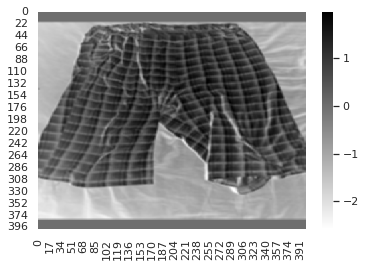

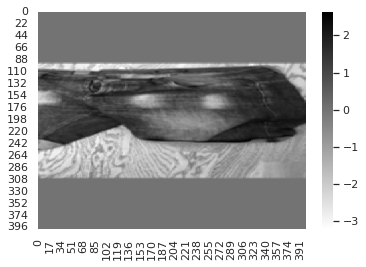

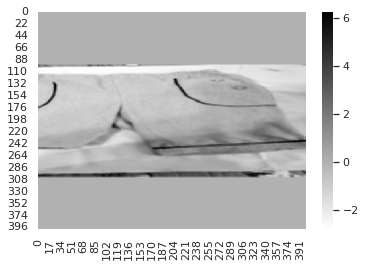

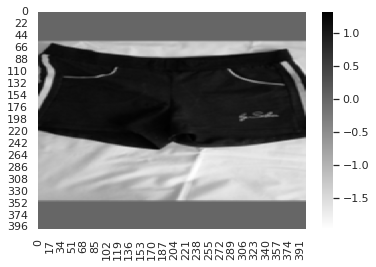

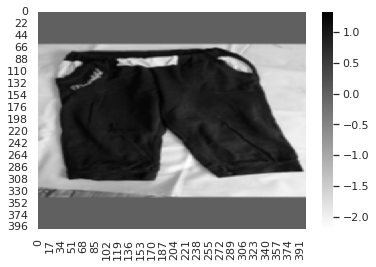

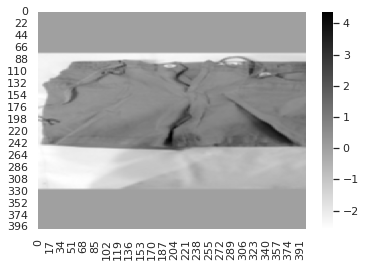

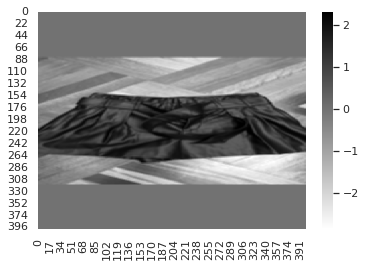

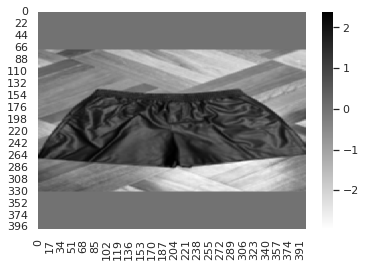

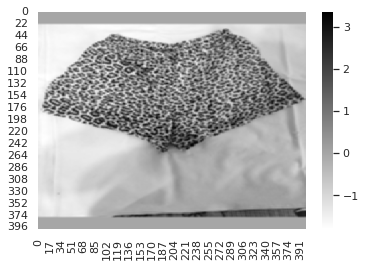

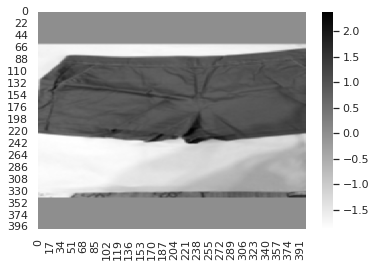

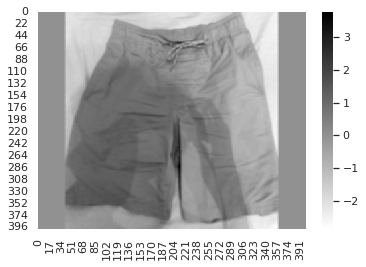

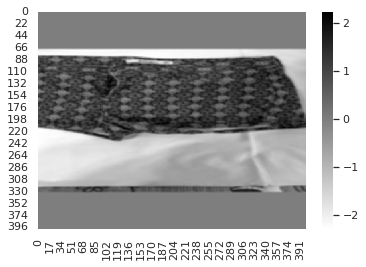

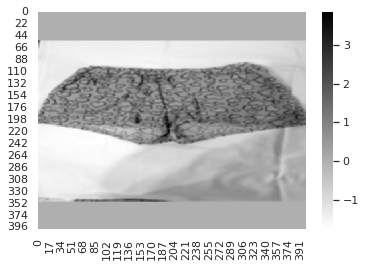

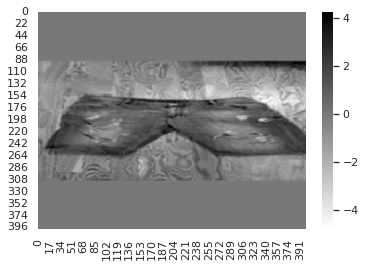

In [7]:
# читаем и обрабатываем фотографии

pictures = []
target = []

for cat in categories:
    path = os.path.join(dirname, cat)
    for img in os.listdir(path):
        pictures.append(prepare_picture1(os.path.join(path, img), n=400))
        target.append(cat)
        sns.heatmap(pictures[-1], cmap='binary')
        plt.show()
        
        
pictures = np.array(pictures)
target = np.array(target)

shirts: 13
sweaters: 12
T-shirts: 17
skirts: 17
pants: 16
dresses: 12
shorts: 19


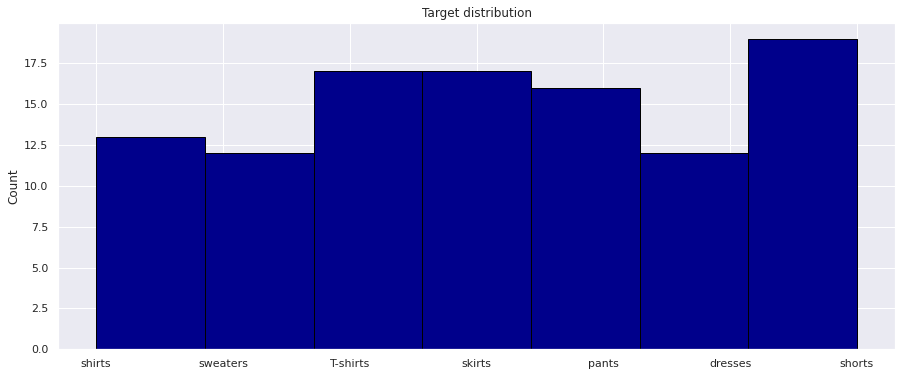

In [8]:
# смотрим на датасет

counter = Counter(target)
for el in counter:
    print(el + ':', counter[el])
    
    
plt.figure(figsize=(15, 6))
plt.hist(target, bins=7, color='darkblue', edgecolor='black')
plt.ylabel('Count')
plt.title('Target distribution')
plt.show()

In [9]:
# эстиматоры, пока обойдемся без бустинга, его попробуем после нормального построения признаков

rf = RandomForestClassifier(random_state=0)

In [10]:
def score_estimator(df, target, features, estimator, scoring, evals=True, proba=True, n=100):
    df_cut = df[features]
           
    scores = []

    for i in range(n):
        
        X_train_all, X_test, y_train_all, y_test = train_test_split(df_cut.values, target, test_size=0.2)
        if evals:
            X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.25)
            estimator.fit(X_train, y_train, eval_set=(X_val, y_val))
            if proba:
                y_pred = [pr[1] for pr in estimator.predict_proba(X_test)]
            else:
                y_pred = estimator.predict(X_test)
            score = scoring(y_test, y_pred)
            scores.append(score)
        else:
            estimator.fit(X_train_all, y_train_all)
            if proba:
                y_pred = [pr[1] for pr in estimator.predict_proba(X_test)]
            else:
                y_pred = estimator.predict(X_test)
            score = scoring(y_test, y_pred)
            scores.append(score)
    
    print('mean score {:.4f} +- {:.4f}'.format(np.mean(scores), np.std(scores)))

In [12]:
# перебираем параметр ширины колонки гистограммы и некоторые параметры эстиматоров, проводим кроссвалидацию

from sklearn.model_selection import GridSearchCV
for h in [20, 25]:
    for a in [400, 200, 100, 80]:
        print(f'h = {h}, a = {a}')
        df_h = make_features(pictures, hist_step=h, angle_step=a)
        parameters_rf = {'max_depth':range(2, 10)}
        clf_rf = GridSearchCV(rf, parameters_rf, scoring='accuracy')
        clf_rf.fit(df_h, target)
        print(f'RF: accuracy {clf_rf.best_score_:.3} {clf_rf.best_params_}')
        #score_estimator(df_h, target, features=df_h.columns, estimator=cat, scoring=accuracy_score, evals=True, proba=False, n=5)

h = 20, a = 400
RF: accuracy 0.48 {'max_depth': 4}
h = 20, a = 200
RF: accuracy 0.461 {'max_depth': 4}
h = 20, a = 100
RF: accuracy 0.51 {'max_depth': 6}
h = 20, a = 80
RF: accuracy 0.481 {'max_depth': 7}
h = 25, a = 400
RF: accuracy 0.491 {'max_depth': 6}
h = 25, a = 200
RF: accuracy 0.48 {'max_depth': 8}
h = 25, a = 100
RF: accuracy 0.509 {'max_depth': 7}
h = 25, a = 80
RF: accuracy 0.423 {'max_depth': 6}


In [13]:
df = make_features(pictures, hist_step=20, angle_step=100)

In [14]:
rf = RandomForestClassifier(random_state=0, max_depth=6)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=3)

In [16]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5

In [19]:
parameters_rf = {'max_depth':range(2, 10)}
    

for n in range(3, 21):
    selector = RFE(rf, n_features_to_select=n, step=1)
    selector = selector.fit(df, target)
    new_df = df[df.columns[selector.support_]]
    clf_rf = GridSearchCV(rf, parameters_rf, scoring='accuracy', cv=5)
    clf_rf.fit(new_df, target)
    print(f'{n} RF: accuracy {clf_rf.best_score_:.3} {clf_rf.best_params_}')

3 RF: accuracy 0.415 {'max_depth': 2}
4 RF: accuracy 0.471 {'max_depth': 5}
5 RF: accuracy 0.481 {'max_depth': 5}
6 RF: accuracy 0.481 {'max_depth': 9}
7 RF: accuracy 0.49 {'max_depth': 5}
8 RF: accuracy 0.566 {'max_depth': 9}
9 RF: accuracy 0.556 {'max_depth': 9}
10 RF: accuracy 0.547 {'max_depth': 5}
11 RF: accuracy 0.585 {'max_depth': 7}
12 RF: accuracy 0.566 {'max_depth': 7}
13 RF: accuracy 0.546 {'max_depth': 5}
14 RF: accuracy 0.509 {'max_depth': 4}
15 RF: accuracy 0.538 {'max_depth': 6}
16 RF: accuracy 0.556 {'max_depth': 8}
17 RF: accuracy 0.546 {'max_depth': 7}
18 RF: accuracy 0.556 {'max_depth': 4}
19 RF: accuracy 0.528 {'max_depth': 8}
20 RF: accuracy 0.528 {'max_depth': 9}


In [20]:
selector = RFE(rf, n_features_to_select=11, step=1)
selector = selector.fit(df, target)
new_features = df.columns[selector.support_]
print(new_features)
new_df = df[new_features]
clf_rf = GridSearchCV(rf, parameters_rf, scoring='accuracy', cv=5)
clf_rf.fit(new_df, target)
print(f'{n} RF: accuracy {clf_rf.best_score_:.3} {clf_rf.best_params_}')

Index(['grad_0_100_6', 'grad_0_300_0', 'grad_0_300_5', 'grad_200_0_8',
       'grad_200_200_1', 'h_100', 'w_120', 'h_200', 'w_200', 'h_220', 'h_280'],
      dtype='object')
20 RF: accuracy 0.585 {'max_depth': 7}


In [21]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(clf_rf.best_estimator_, file)